In [32]:
import sys 
import os 
# Add the project root to sys.path
sys.path.append(os.path.abspath('../'))

from Util.Client import download_file, example_key, example_file_name

print(example_key)
print(example_file_name)

ds000228/sub-pixar001/anat/sub-pixar001_T1w.nii.gz
sub-pixar001_T1w.nii.gz


In [33]:
download_file(
    key = example_key,
    the_file_name_you_want = example_file_name
)

'Downloaded to ../Data/sub-pixar001_T1w.nii.gz'

In [34]:
import nibabel as nib

img = nib.load('..\Data\sub-pixar001_T1w.nii.gz')

print(img)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (176, 192, 192)
affine:
[[   1.            0.            0.          -84.5       ]
 [   0.            0.97629595   -0.21643978  -60.18632507]
 [   0.            0.21643978    0.97629595 -131.30987549]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 54
dim             : [  3 176 192 192   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.   1.   1.   1.   2.53 0.   0.   0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0

In [35]:
img.header['sform_code']

array(1, dtype=int16)

In [36]:
img.shape

(176, 192, 192)

In [37]:
# An array of images
# each image is from the mri scan
# each image is a `slice` of the brain
mri_scan = img.get_fdata()

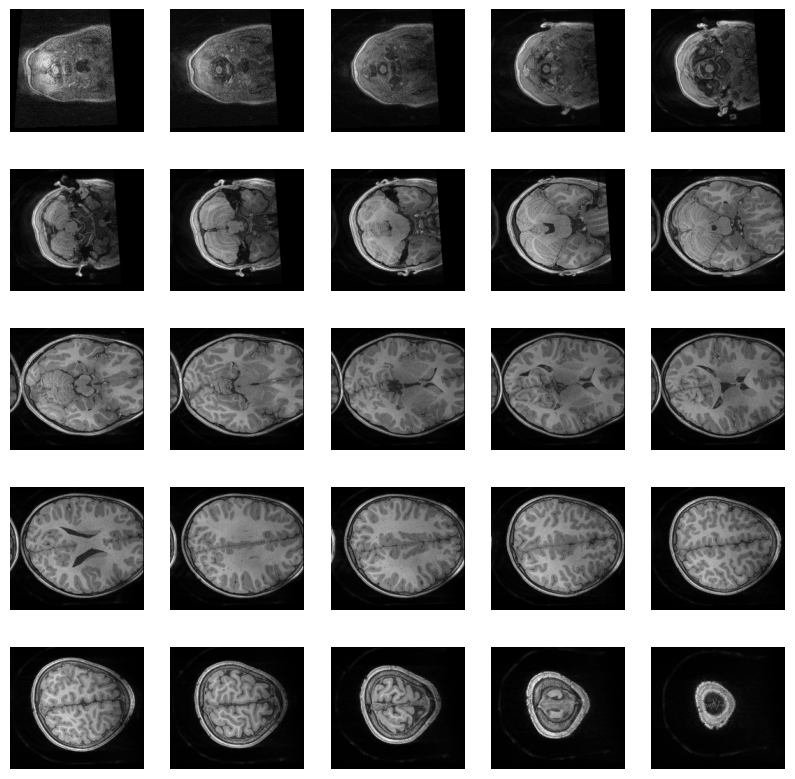

In [38]:
import matplotlib.pyplot as plt
import numpy as np 

def plot_img(img_array: np.array, n: int = 5) -> None:
    fig, axis = plt.subplots(
        nrows = n,
        ncols = n,
        figsize = (10, 10)
    )

    xMax, yMax, zMax = img_array.shape
    step = zMax // (n**2) # n^2 = total number of slices we're graphing 

    current_slice = 0 # index of current slice from the MRI scan
    # for each axis ...
    for x_center in range(n):
        for y_center in range(n):

            axis[x_center][y_center].imshow(
                mri_scan[:, :, current_slice],
                cmap = 'gray',
            )

            axis[x_center][y_center].axis('off')

            current_slice += step

plot_img(img.get_fdata())

In [39]:
# The strategy is to determine age or gender from MRIs
# According to ChatGPT: If you want to identify age-related patterns in your MRI dataset, while participants watch a Pixar movie
# Look at:
#   MRI's mid-to-high slices roughly z=20 to 50 mm in MNI space for 
#       PFC,
#       posterioir cingulate, 
#       and temporal lobes

In [40]:
from nilearn import datasets, image, plotting
import nibabel as nib

# Load the probabilistic atlas
ho_atlas = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')

atlas_label_to_index = {label : i for i, label in enumerate(ho_atlas.labels[1:])} # skip background 
atlas_label_to_index

[fetch_atlas_harvard_oxford] Dataset found in C:\Users\danie\nilearn_data\fsl


{'Frontal Pole': 0,
 'Insular Cortex': 1,
 'Superior Frontal Gyrus': 2,
 'Middle Frontal Gyrus': 3,
 'Inferior Frontal Gyrus, pars triangularis': 4,
 'Inferior Frontal Gyrus, pars opercularis': 5,
 'Precentral Gyrus': 6,
 'Temporal Pole': 7,
 'Superior Temporal Gyrus, anterior division': 8,
 'Superior Temporal Gyrus, posterior division': 9,
 'Middle Temporal Gyrus, anterior division': 10,
 'Middle Temporal Gyrus, posterior division': 11,
 'Middle Temporal Gyrus, temporooccipital part': 12,
 'Inferior Temporal Gyrus, anterior division': 13,
 'Inferior Temporal Gyrus, posterior division': 14,
 'Inferior Temporal Gyrus, temporooccipital part': 15,
 'Postcentral Gyrus': 16,
 'Superior Parietal Lobule': 17,
 'Supramarginal Gyrus, anterior division': 18,
 'Supramarginal Gyrus, posterior division': 19,
 'Angular Gyrus': 20,
 'Lateral Occipital Cortex, superior division': 21,
 'Lateral Occipital Cortex, inferior division': 22,
 'Intracalcarine Cortex': 23,
 'Frontal Medial Cortex': 24,
 'Juxta

In [ ]:
# Prefontal Cortex (PFC)
# Made up of multiple brain regions as seen in the list below
# We use the harvard oxford atlas labels to see the index of each brain region that makes up the PFC

# Question, this list represents the index of multiple 3D numpy array. How do we merge it?
# Answer: See the implementation below 

# Terminology:
# ROI - Region of Interest . look it up lol

In [46]:
pfc_roi_indicies = [
    atlas_label_to_index['Frontal Pole'],
    atlas_label_to_index['Superior Frontal Gyrus'],
    atlas_label_to_index['Middle Frontal Gyrus'],
    atlas_label_to_index['Inferior Frontal Gyrus, pars triangularis'],
    atlas_label_to_index['Inferior Frontal Gyrus, pars opercularis'],
    atlas_label_to_index['Frontal Medial Cortex'],
    atlas_label_to_index['Paracingulate Gyrus'],
    atlas_label_to_index['Cingulate Gyrus, anterior division'],
    atlas_label_to_index['Frontal Orbital Cortex']
]
pfc_roi_indicies

[0, 2, 3, 4, 5, 24, 27, 28, 32]

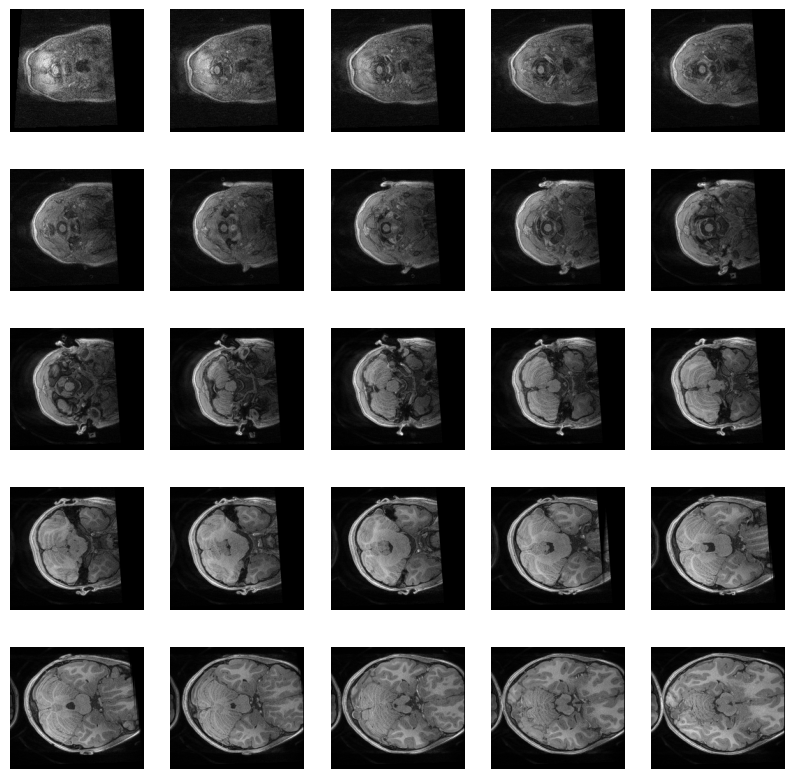

In [ ]:
atlas_img = ho_atlas.maps
atlas_img_data = atlas_img.get_fdata()

# 1. Set a mask of all 0s with the same 3D shape
pfc_mask = np.zeros(
    shape = atlas_img_data.shape[:3],
    dtype = bool
)

# For each brain region, use a logical or to update the mask
# update the mask at coord (x,y,z) to true if the current ROI at coord(x, y, z) > 50% probability 
# The current ROI at coord (x,y,z) i.e the voxel has a value of 0–100.
# the value indicates the likelihood (%) that the voxel belongs to a given ROI.
for roi_idx in pfc_roi_indicies:
    roi_prob = atlas_img_data[..., roi_idx]
    pfc_mask |= (roi_prob >= 50)

plot_img(pfc_mask)